#### Load drive if necessary

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Imports

In [16]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision.utils import make_grid
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.models as models
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = ("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(66)

#### Functions

In [17]:
def imshow(img):
      """
      Input: torchvision.utils.make_grid(images)

      Output: batch of random images
      """
      img = img / 2 + 0.5     # unnormalize
      npimg = img.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      plt.show()



def train():
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(train_loader, total=len(train_loader), leave=True)
       
        for imgs, labels in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
            loop.set_postfix(loss = loss.item())


def check_accuracy(loader, model):
    """
    Input: dataloader, model

    Output: Accuracy of model
    """
    if loader == train_loader:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on validation data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            predictions = torch.argmax(scores,dim=1).to(device)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    return f"{float(num_correct)/float(num_samples)*100:.2f}", (f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}" )
    model.train()




def get_predictions(loader):
  """

  Input : Loader for which predictions are needed

  Output : y_pred, y_true

  """

  #Get true and predicted values for confusion matrix
  y_pred = []
  y_true = []

  # iterate over test data
  for inputs, labels in loader:
          output = model(inputs) # Feed Network

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth
          
  return y_pred, y_true



def graph_cf(matrix, title, save=True):
  """

  Input: confusion matrix, title of plot, save (True, False)

  Output: Graph of confusion matrix normalized to its own class


  """

  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix, axis=0), index = [i for i in classes],
                      columns = [i for i in classes])
  fig = plt.figure(figsize = (12,7))
  sns.heatmap(df_cm, annot=True)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.title(f'{title}')
  plt.show()

  if save:
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/AI for coral reef/'+f'{title}'+'_cf_matrix'+'.png')
  else:
    pass

  return 


#### Image Preprocessing

In [4]:
encoding = {'Algae':0,'Hard Coral':1,'Other':2,'Soft Coral':3,'Other Invertebrates':4,'Sponge':5}

In [5]:
classes = encoding.keys()
classes = list(classes)

In [6]:
# Transforms PIL image to Tensor
pil2tensor = transforms.ToTensor()
# The pretrained net requieres that the images are normalized 
normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))


class Coralscrop(Dataset):

    """
    Input: annotation file with column_0 = image name,
                                column_1 = y coordinate of labeled dot
                                column_2 = x coordinate of labeled dot
                                func_group column corresponding to the previously encoded categories

            folder with images coresponding to the annotation file

    Output: images, labels
    """

    def __init__(self, root_dir, annotation_file):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, str(img_id)+".jpg")).convert("RGB")
        left = self.annotations.iloc[index, 2]-150
        top = self.annotations.iloc[index, 1]-150
        img = transforms.functional.crop(img,top,left,300,300)
        img = pil2tensor(img)
        img = normalize(img)
        y_label = torch.tensor(int(encoding[self.annotations.loc[index,'func_group']]))

        return (img, y_label)

### Define datasets

In [7]:
batch_size = 32

In [8]:
ConcatDataset = torch.utils.data.ConcatDataset

In [9]:
# Define datasets
#annotations_1 = "/content/drive/MyDrive/SEAVIEW/IND_CHA"
#directory_1 = "/content/drive/MyDrive/SEAVIEW/tabular-data/annotations_IND_CHA.csv"
#dataset1 = Coralscrop(annotations_1, directory_1)

annotations_2 = "/content/drive/MyDrive/SEAVIEW/ATL"
directory_2 = "/content/drive/MyDrive/SEAVIEW/tabular-data/annotations_ATL.csv"
dataset2 = Coralscrop(annotations_2, directory_2)

# Concatenate datasets
#ConcatDataset = torch.utils.data.ConcatDataset
#dataset = ConcatDataset([dataset1,dataset2])
dataset = dataset2

# Divide datasets in train and test
# If shows an error, try different values of random split
train_set, test_set = torch.utils.data.random_split(dataset,[int(len(dataset)*0.8),int(len(dataset)*0.2)])
# Divide train_set into train and validation sets
train_set, validation_set = torch.utils.data.random_split(train_set,[int(len(train_set)*0.8),int(len(train_set)*0.2)])

train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(dataset=test_set, shuffle=True, batch_size=batch_size, num_workers=2)
validation_loader = DataLoader(dataset=validation_set, shuffle=True, batch_size=batch_size, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


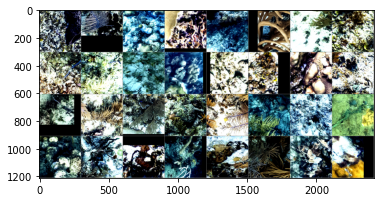

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

### Define model

In [10]:
# Load pretrained GoogLeNet
!pip install timm
import timm
model = timm.create_model('inception_v4', pretrained=True, num_classes=6)
model.eval()


     |████████████████████████████████| 376 kB 12.6 MB/s 


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/inceptionv4-8e4777a0.pth" to /root/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth


InceptionV4(
  (features): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Mixed3a(
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): BasicConv2d(
        (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, mom

In [11]:
# Replace the last fully connected layer (classifier) for the classes we need to classify
#model.fc =  nn.Linear(2048, 6)

# Move device to GPU if available
model.to(device)

InceptionV4(
  (features): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Mixed3a(
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): BasicConv2d(
        (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, mom

#### Set hyperparameters

In [12]:
# Hyperparameters
num_classes = len(classes)
learning_rate = 1e-3
num_epochs = 2


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Run model

In [ ]:
# Train model
train ()

In [ ]:
# Save model weights
path_model = '/content/drive/MyDrive/Colab Notebooks/AI for coral reef/inceptionv4_weight_2.pth'
torch.save(model.state_dict(), path_model)
# Save optimizer state dictionary
optimizer_path = '/content/drive/MyDrive/Colab Notebooks/AI for coral reef/inceptionv4_opt_2.pth'
torch.save(optimizer.state_dict(), optimizer_path)

#### Check model performance

In [13]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/AI for coral reef/inceptionv4_weight.pth', map_location='cuda'))
optimizer.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/AI for coral reef/inceptionv4_opt.pth', map_location='cuda'))

In [ ]:
# Move model to CPU
model.to(device)

In [ ]:
# Check accuracy of model
check_accuracy(validation_loader, model)

Checking accuracy on validation data


('83.33', 'Got 12386 / 14864 with accuracy 83.33')

In [18]:
# Get predicted and true labels
model.to('cpu')
y_pred, y_true = get_predictions(validation_loader)

In [19]:
# Create a confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


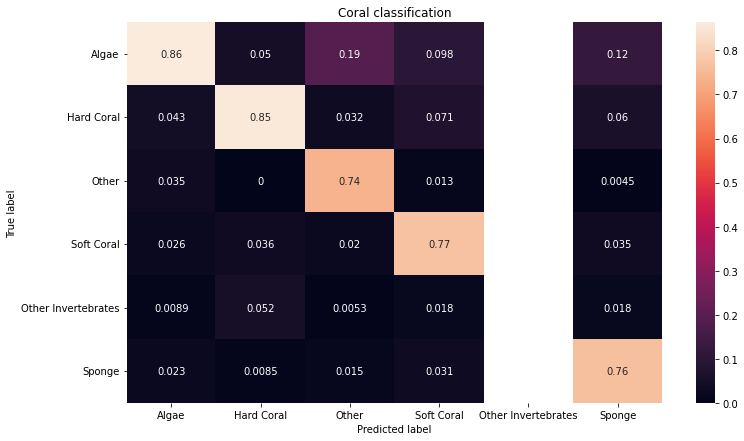

<Figure size 432x288 with 0 Axes>

In [20]:
# Plot confusion matrix for unbalanced classes
graph_cf(cf_matrix, 'Coral classification')